In [1]:
using Plots, PlotThemes, LaTeXStrings
using OffsetArrays
using LinearAlgebra
using FFTW
using StatsBase
using Unitful
using Base: Fix1, Fix2
using Distributions
using ArbNumerics
using Trapz

theme(:mute)
default(;palette=:seaborn_deep6, fontfamily="serif")
j=im

im

In [2]:
S = OffsetArray(sqrt(13/6).*[0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 0,
0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0,0], -26:26)

shift(x) = [i in 1:26 ? x[i] : (i in 38:63 ? x[i-64] : 0.0+im*0.0) for i in 0:63]

function shift(x, ifft_points)
    x_shift = vcat(x[0:26], zeros(ifft_points-53), x[-26:-1])
    return x_shift
end

function make_preamble(sym) 
    sym2 = sym[length(sym)-Int(length(sym)/2)+1:end]
    return vcat(sym2, sym, sym)
end

function freq_to_wave(x, ifft_points)
    return shift(x, ifft_points) |> ifft |> make_preamble
end

function to_db(snr)
    return 10*log10(snr)*1u"dB"
end

to_db (generic function with 1 method)

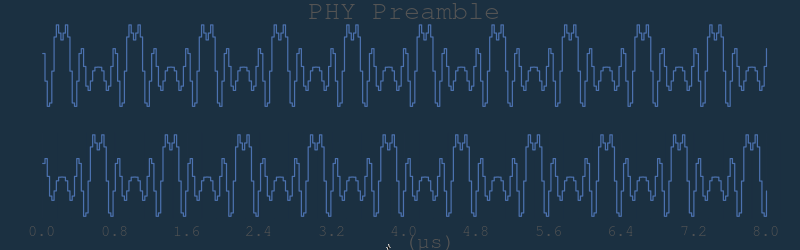

GKS: could not find font serif.ttf


In [3]:
N = 128
sym = freq_to_wave(S, N)
t = range(0u"μs", 8u"μs", length=length(sym))
tiks = [0:0.8:8...]
p2 = plot(t, imag(sym), yticks=false, line=:steppost, ylabel="canal I", xlabel=L"t", xticks = tiks, title="")
p1 = plot(t, real(sym), yticks=false, line=:steppost, ylabel="canal Q", xlabel="", xticks=[], title="PHY Preamble")

plot(p1, p2, layout=(2,1), legend = false, size=(800,250), background_color="#1b3041")

In [4]:
function threshold(PFA, σ, ref)
    return sqrt(-2*log(PFA))*norm(ref)*σ
end

function realization(y, ref, T)
    ϕ = abs(ref'*y)
    return ϕ >= T
end

function int_arg(x, λ)
    x_a = ArbReal(x)
    λ_a = ArbReal(λ)
    return x_a*exp(-(x_a^2+λ_a^2)/2)*besseli(0,λ_a*x_a)
end

function PDofPFA_t(PFA, ref, snr)
    lb = sqrt(-2*log(PFA))
    λ = sqrt(2*length(ref)*snr)
    guard = 7
    if lb < λ - guard
        return 1
    elseif lb > λ + guard
        return 0
    else
        xs = range(lb, λ+guard, length=1000)
        return trapz(xs, [int_arg(x, λ) for x in xs])
    end
end

function test_PD_est(PFA, ref, snr)
    n_realz = 1000/PDofPFA_t(PFA, ref, snr) |> ceil |> Int
    if n_realz >= 100000
        return 0
    end
    ND = 0
    σ = 1
    A = σ*sqrt(2*length(ref)*snr)/norm(ref)
    T = threshold(PFA, σ, ref)
    for i in 1:n_realz
        d = Normal(0, σ)
        N = length(ref)
        noise = rand(d, N) .+ j.*rand(d, N)
        y = A.*ref .+ noise
        if realization(y, ref, T)
            ND += 1
        end
    end
    return ND/n_realz
end

test_PD_est (generic function with 1 method)

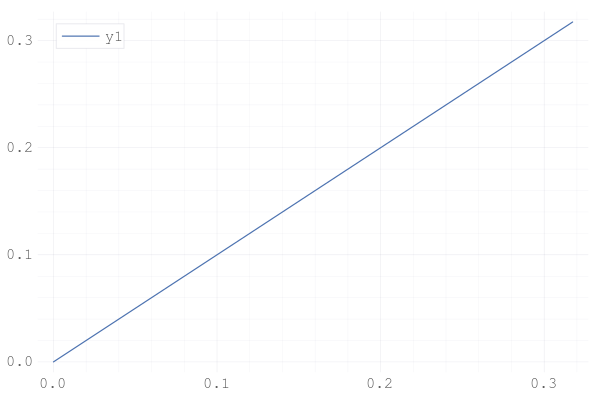

In [5]:
function signal_pow(A)
    y = A.*sym
    return norm(y)^2/length(y)
end

As = 0.1:0.1:10

plot((As.*norm(sym)).^2 ./length(sym), signal_pow.(As))

In [6]:
length(sym)

320

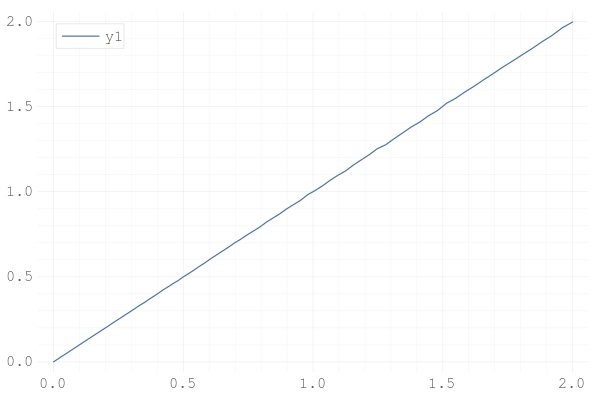

In [7]:
function noise_pow(σ)
    d = Normal(0, σ)
    N = length(sym)
    rsum = 0
    nreal=1000
    for i in 1:nreal
        y = rand(d, N) .+ j.*rand(d, N)
        rsum += norm(y)^2/length(y)
    end
    return rsum/nreal
end
As = 0.01:0.01:1

plot(2 .*As.^2, noise_pow.(As))

In [8]:


## Signal pow = (A*||s||)^2/N
## Noise pow = 2*σ^2

## SNR = (A|s|)^2/(2Nσ^2)
## A|s|/σ = sqrt(2N*SNR)


┌ Info: 0.7938223013709342
└ @ Main /home/inox/Documents/IB/Tésis/false_alarm_test_snr.ipynb:35
┌ Info: 0.2510286529768756
└ @ Main /home/inox/Documents/IB/Tésis/false_alarm_test_snr.ipynb:40


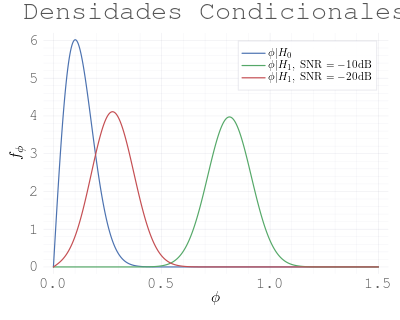

In [9]:
function f_1(x, ref, snr)
    x_a = ArbReal(x)
    λ_a = ArbReal(sqrt(2*length(ref)*snr))
    return x_a*exp(-(x_a^2+λ_a^2)/2)*besseli(0,λ_a*x_a)
end

function f_1(x, ref, A, σ)
    x_a = ArbReal(x)
    n = norm(ref)
    return x_a/(n*σ)^2*exp(-(x_a^2/n^2+A^2*n^2)/(2*σ^2))*besseli(0,A*x_a/σ^2)
end


function f_0(x, ref, σ)
    x_a = ArbReal(x)
    return x_a/(norm(ref)*σ)^2*exp(-x_a^2/(2*norm(ref)^2*σ^2))
end

function F_0(x, ref, σ, A)
    return 1-exp(-x^2/(2*norm(ref)^2*σ^2))
end

function snr_calc(A, σ, ref)
    return (A*norm(ref))^2/(2*length(ref)*σ^2)
end


xs = range(0, 1.5, length=1000)
σ = 0.1

p1 = plot(xs, [f_0(x,sym,σ) for x in xs], label=L"\phi|H_0", xlabel=L"\phi", ylabel=L"f_\phi", title="Densidades Condicionales", size=(500,400).*0.8)

snr = 10^(-10/10)
A = sqrt(2*length(sym)*snr)*σ/norm(sym)
@info A
plot!(p1, xs, [f_1(x,sym,A,σ) for x in xs], label=L"\phi|H_1,\;\mathrm{SNR}=-10\mathrm{dB}")

snr = 10^(-20/10)
A = sqrt(2*length(sym)*snr)*σ/norm(sym)
@info A
plot!(p1, xs, [f_1(x,sym,A,σ) for x in xs], label=L"\phi|H_1,\;\mathrm{SNR}=-20\mathrm{dB}")


In [10]:
savefig("Avance 2/Images/f_cond.svg")

"/home/inox/Documents/IB/Tésis/Avance 2/Images/f_cond.svg"

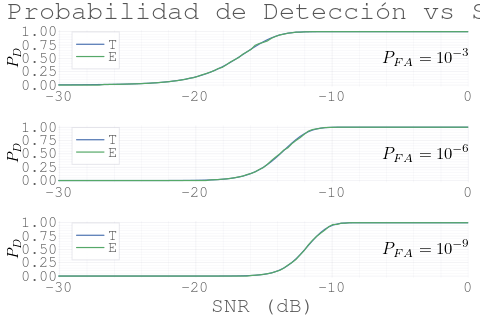

In [11]:
snrs = 2.0 .^(-10:0.1:0)

PFA=1e-3
p1 = plot(to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel=L"P_D", xlabel="", label="T",title="Probabilidad de Detección vs SNR", xlims=extrema(ustrip.(to_db.(snrs))))
plot!(p1, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], xlabel="", label="E")
annotate!(0, 0.5,(L"P_{FA}=10^{-3}", 12, :right))
PFA=1e-6
p2 = plot(to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel=L"P_D", xlabel="", label="T", xlims=extrema(ustrip.(to_db.(snrs))))
plot!(p2, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], xlabel="", label="E")
annotate!(0, 0.5,(L"P_{FA}=10^{-6}", 12, :right))
PFA=1e-9
p3 = plot(to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel=L"P_D", label="T", xlabel="SNR", xlims=extrema(ustrip.(to_db.(snrs))))
plot!(p3, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], label="E")
annotate!(0, 0.5,(L"P_{FA}=10^{-9}", 12, :right))

plot(p1,p2,p3, layout=(3,1), legend=:topleft, size=(600,400).*0.8)

In [12]:
savefig("Avance 2/Images/pd_vs_snr.svg")

"/home/inox/Documents/IB/Tésis/Avance 2/Images/pd_vs_snr.svg"

In [13]:
#snrs = 2 .^(-6:0.1:0)
#
#PFA=1e-3
#p1 = plot(to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], color=plt[1], label=L"P_{FA}=10^{%$(log10(PFA)|>Int)}")
#plot!(p1, to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], color=plt[1], linestyle=:dash, label="", ylabel=L"P_D")
#PFA=1e-6
#plot!(p1, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], color=plt[2], label=L"P_{FA}=10^{%$(log10(PFA)|>Int)}")
#plot!(p1, to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], color=plt[2], linestyle=:dash, label="")
#PFA=1e-9
#plot!(p1, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], color=plt[3], label=L"P_{FA}=10^{%$(log10(PFA)|>Int)}")
#plot!(p1, to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], color=plt[3], linestyle=:dash, label="")
#PFA=1e-12
#plot!(p1, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], color=plt[4], label=L"P_{FA}=10^{%$(log10(PFA)|>Int)}")
#plot!(p1, to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], color=plt[4], linestyle=:dash, label="", xlabel="SNR")
#

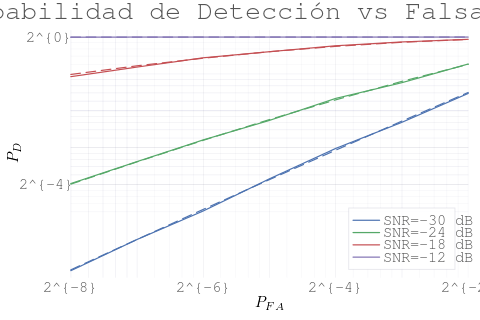

In [14]:
PFAs = 2.0 .^(-8:1:-2)

plt = palette(:seaborn_deep6)

snr=2.0^-10
p1 = plot(PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[1], ylabel=L"P_D", label="SNR=$(Int(round(ustrip(to_db(snr))))*1u"dB")", xaxis=:log2, yaxis=:log2, xlabel=L"P_{FA}", legend=:bottomright, xlims=extrema(PFAs), size=(600,400).*0.8, title="Probabilidad de Detección vs Falsa Alarma")
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[1], label="", linestyle=:dash)
snr=2.0^-8
plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[2],label="SNR=$(Int(round(ustrip(to_db(snr))))*1u"dB")")
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[2], label="", linestyle=:dash)
snr=2.0^-6
plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[3],label="SNR=$(Int(round(ustrip(to_db(snr))))*1u"dB")")
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[3], label="", linestyle=:dash)
snr=2.0^-4
plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[4],label="SNR=$(Int(round(ustrip(to_db(snr))))*1u"dB")")
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[4], label="", linestyle=:dash)

In [15]:
savefig("Avance 2/Images/pd_vs_pfa.svg")

"/home/inox/Documents/IB/Tésis/Avance 2/Images/pd_vs_pfa.svg"

In [16]:
function estimate_noise(y)
    return norm(y)^2/(2*(length(y)-1))
end

function test_PD_est(PFA, ref, snr)
    n_realz = 1000/PDofPFA_t(PFA, ref, snr) |> ceil |> Int
    if n_realz >= 100000
        return 0
    end
    ND = 0
    σ = 1
    A = σ*sqrt(2*length(ref)*snr)/norm(ref)
    for i in 1:n_realz
        d = Normal(0, σ)
        N = length(ref)
        noise = rand(d, N) .+ j.*rand(d, N)
        y = A.*ref .+ noise
        σ_est = sqrt(estimate_noise(y))
        T = threshold(PFA, σ_est, ref)
        if realization(y, ref, T)
            ND += 1
        end
    end
    return ND/n_realz
end

test_PD_est (generic function with 1 method)

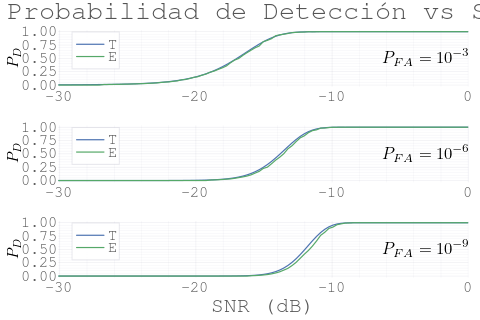

In [17]:
snrs = 2.0 .^(-10:0.1:0)

PFA=1e-3
p1 = plot(to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel=L"P_D", xlabel="", label="T",title="Probabilidad de Detección vs SNR", xlims=extrema(ustrip.(to_db.(snrs))))
plot!(p1, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], xlabel="", label="E")
annotate!(0, 0.5,(L"P_{FA}=10^{-3}", 12, :right))
PFA=1e-6
p2 = plot(to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel=L"P_D", xlabel="", label="T", xlims=extrema(ustrip.(to_db.(snrs))))
plot!(p2, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], xlabel="", label="E")
annotate!(0, 0.5,(L"P_{FA}=10^{-6}", 12, :right))
PFA=1e-9
p3 = plot(to_db.(snrs), [PDofPFA_t(PFA, sym, snr) for snr in snrs], ylabel=L"P_D", label="T", xlabel="SNR", xlims=extrema(ustrip.(to_db.(snrs))))
plot!(p3, to_db.(snrs), [test_PD_est(PFA, sym ,snr) for snr in snrs], label="E")
annotate!(0, 0.5,(L"P_{FA}=10^{-9}", 12, :right))

plot(p1,p2,p3, layout=(3,1), legend=:topleft, size=(600,400).*0.8)

In [18]:
savefig("Avance 2/Images/pd_vs_snr2.svg")

"/home/inox/Documents/IB/Tésis/Avance 2/Images/pd_vs_snr2.svg"

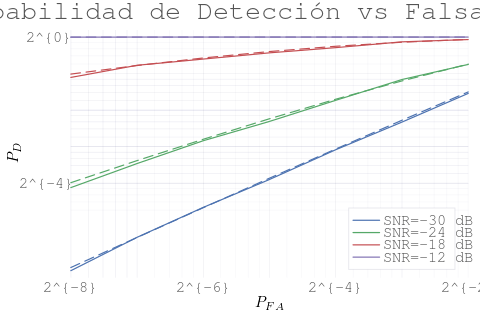

In [19]:
PFAs = 2.0 .^(-8:1:-2)

plt = palette(:seaborn_deep6)

snr=2.0^-10
p1 = plot(PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[1], ylabel=L"P_D", label="SNR=$(Int(round(ustrip(to_db(snr))))*1u"dB")", xaxis=:log2, yaxis=:log2, xlabel=L"P_{FA}", legend=:bottomright, xlims=extrema(PFAs), size=(600,400).*0.8, title="Probabilidad de Detección vs Falsa Alarma")
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[1], label="", linestyle=:dash)
snr=2.0^-8
plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[2],label="SNR=$(Int(round(ustrip(to_db(snr))))*1u"dB")")
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[2], label="", linestyle=:dash)
snr=2.0^-6
plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[3],label="SNR=$(Int(round(ustrip(to_db(snr))))*1u"dB")")
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[3], label="", linestyle=:dash)
snr=2.0^-4
plot!(p1, PFAs, [test_PD_est(PFA, sym, snr) for PFA in PFAs], color=plt[4],label="SNR=$(Int(round(ustrip(to_db(snr))))*1u"dB")")
plot!(p1, PFAs, [PDofPFA_t(PFA, sym, snr) for PFA in PFAs], color=plt[4], label="", linestyle=:dash)

In [20]:
savefig("Avance 2/Images/pd_vs_pfa2.svg")

"/home/inox/Documents/IB/Tésis/Avance 2/Images/pd_vs_pfa2.svg"

In [22]:
PFA = 1e-6
σ_est = 0.15

0.15

In [23]:
T = threshold(PFA, σ_est, sym)

0.794614375637303

In [24]:
T*1e3

794.6143756373029